# Notes

- Found a fatal flaw at 00:50, 26/12/23: the MC is not irreducible on the thorus! there are closed paths with non defined interior/exterior (the ones that cross the tp), sho you can't fill them with uniform +1 and remove.... Probably should swith to different boundary conditions.

# TODOs
- implement free boundary conditions (new code)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import random
from scipy.optimize import curve_fit

from functools import wraps
import time



In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time: e} seconds')
        return result
    return timeit_wrapper

def infer_style():
    for style_name, style_params in plt.style.library.items():
        if all(key in plt.rcParams and plt.rcParams[key] == val for key, val in style_params.items()):
            return style_name
    return 'Default'


# add matplotlib style decorator!

In [285]:
# define the state space
# m = (m_r, m_g, m_b) 3 colors
# the grid is from (0,0) to (n,n) make NxN square, each is a 2 dim list, each vertex has an horizontal and vertical edges like so:
#               0
#             ----(x,y)
#                   |    1
#                   |
#
# the 4 directions are encoded as:
#                     0
#                  -------
#             3    |     |   1
#                  |_____|
#                     2
#

class stateSpace:
    def __init__(self, num_colors, grid_size, beta, init = 0, algo = 'metropolis'):  # 'glauber'
    
        self.grid_size = grid_size
        self.V = grid_size**2
        self.num_colors = num_colors
        self.beta = beta
        self.data1 = []
        self.data2 = []
        self.accepted = 0
        self.rejected = 0
        self.loops = 0
        self.algo = algo
        
        self.shape = (num_colors, grid_size, grid_size, 2)    # (2, 2, 2, 2)

        self.grid = np.zeros(self.shape, dtype=int)
        

        if init == 'random':
            #self.random_init()
            self.grid[0, 0, 0, 1] = 1 
            self.grid[0, 0, 1, 1] = 1
            self.data2.append(self.grid[0])
            
        elif init:
            self.uniform_init(init)

    def random_init(self):
        self.grid = 2*np.random.randint(0, 10, size = self.shape, dtype=int)

    def uniform_init(self, k):
        self.grid = k*np.ones(self.shape, dtype=int)

    def step(self, num_steps = 1):
        print('using {} acceptance probability'.format(self.algo))
        for i in trange(num_steps):
            if sum(sum(sum(self.grid[0]))) == 0:
                print("empty state reached at step {}".format(i))
                break 
            # choose a random color 
            c = 0 # np.random.randint(0, self.num_colors, dtype=int)
         
            # choose a random square
            s = np.random.randint(0, self.grid_size, size = 2, dtype=int)

            # get num_link on each side of square s
            S = np.zeros(4, dtype=int)
            S[0] = self.grid[c, s[0], s[1], 0]
            S[2] = self.grid[c, s[0], (s[1]-1) % self.grid_size, 0]
            S[1] = self.grid[c, s[0], s[1], 1]
            S[3] = self.grid[c, (s[0]-1) % self.grid_size, s[1], 1]

            # get list of all possible transformation
            transformations = self.get_possible_transformations(S)
            
            # pick uniformly a transformation
            M = len(transformations)   # num of possible transformation of current state, compute only once! we also need it to compute tha ratio M/M_prime in acceptance_prob
            index = np.random.randint(0, M)  
            X = transformations[index]
            #print('transformation: {}'.format(X))
            
            if self.acceptance_prob(c, S, M, s, X) >= random.random():
                self.accepted += 1
                self.data2.append(self.grid[0])
                if X[0] == -1:
                    self.uniform(c, s, X[1])
                elif X[0] >= 0:
                    self.single(c, s, X[0], X[1])
                else:
                    self.loops += 1
                    self.loop(c, X[0], s)
            else:
                self.rejected += 1

            # store data
            #if i % 10_000 == 0:
            #    pass
                #self.data1.append(self.get_avg_links())
                #self.data2.append(self.get_max_links())
            
    
    def get_possible_transformations(self, S):
        # list of all possible transformations
        transformations = [(-1, 1), (-1,-1), (0, 2), (0, -2), (1, 2), (1, -2), (2, 2), (2, -2), (3, 2), (3, -2), (-2, 1), (-3, 1)] # (-1,1): uniform +1, (-1,-1): uniform -1, (0,2): single top +2, (0,-2): single top -2, etc...  (-2, 1), (-3, 1) are H and V 
        if S[0] < 2:
            transformations.remove( (0,-2) )
            if S[0] == 0:
                transformations.remove((-1,-1))
        if S[2] < 2:
            transformations.remove((2,-2))
            if S[2] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        if S[1] < 2:
            transformations.remove((1,-2))
            if S[1] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        if S[3] < 2:
            transformations.remove((3,-2))
            if S[3] == 0:
                if (-1,-1) in transformations: transformations.remove((-1,-1))
        return transformations

    def uniform(self, c, s, n):
        # add +n to top and right
        self.grid[c, s[0], s[1]] += np.array([n, n])

        # add +n to left
        self.grid[c, (s[0] - 1) % self.grid_size, s[1], 1] += n

         # add +n to bottom
        self.grid[c, s[0], (s[1] -1) % self.grid_size, 0] += n

    def single(self, c, s, d, n):
        # left
        if d == 3:
            self.grid[c, (s[0]-1) % self.grid_size, s[1], 1] += n
        # bottom
        elif d == 2:
            self.grid[c, s[0], (s[1]-1) % self.grid_size, 0] += n
        # top and right
        else:
            self.grid[c, s[0], s[1], d] += n
    
    def loop(self, c, d, s):
        if d == -2: #horizontal
            for x in range(self.grid_size):
                self.grid[c, x, s[1], 0] += 1
        else: #vertical
            for y in range(self.grid_size):
                self.grid[c, s[0], y, 1] += 1
    
    def acceptance_prob(self, c, S, M, s, X):
        # possible transformation ratio
        S_prime = np.copy(S) 
        if X[0] == -1: # uniform
            S_prime += np.array([X[1], X[1], X[1], X[1]])
        elif X[0] >= 0: #single
            S_prime[X[0]] += X[1]
        elif X[0] == -2: #loop horizontal
            S_prime[0] += 1
        else:      #loop vertical
            S_prime[1] += 1


        #get M_prime, the number of possibile transformation of the new state
        M_prime = len(self.get_possible_transformations(S_prime))

        # prob ration 
        if X[0] == -1:
            if X[1] == 1:
                # get local times
                A = self.beta**4 / (16 * (S[0] + 1)*(S[1] + 1)*(S[2] + 1)*(S[3] + 1) 
                                    *(self.num_colors/2 + self.get_local_time(s[0], s[1]))
                                    *(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size))
                                    *(self.num_colors/2 + self.get_local_time((s[0]-1) % self.grid_size, s[1]))
                                    *(self.num_colors/2 + self.get_local_time((s[0]-1) % self.grid_size, (s[1]-1) % self.grid_size))
                                    )
            else:
                # get local times
                A = 16 / (self.beta**4) * S[0]*S[1]*S[2]*S[3] *(self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size) - 1)*(self.num_colors/2 + self.get_local_time((s[0]-1) % self.grid_size, s[1]) - 1)*(self.num_colors/2 + self.get_local_time((s[0]-1) % self.grid_size, (s[1]-1) % self.grid_size) - 1)
        elif X[0] == 0:
            if X[1] == -2:
                A = 4 * S[0]*(S[0]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time((s[0]-1) % self.grid_size, s[1]) - 1) 
            else:
                A = self.beta**2/ (4*(S[0]+2)*(S[0]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time( (s[0]-1) % self.grid_size, s[1]))  )
        elif X[0] == 1:
            if X[1] == -2:
                A = 4 * S[1]*(S[1]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size) - 1) 
            else:
                A = self.beta**2/ (4*(S[1]+2)*(S[1]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size))  )
        elif X[0] == 2:
            if X[1] == -2:
                A = 4 * S[2]*(S[2]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( (s[0]-1) % self.grid_size, (s[1]-1) % self.grid_size) - 1)*(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size) - 1) 
            else:
                A = self.beta**2/ (4*(S[2]+2)*(S[2]+1)*(self.num_colors/2 + self.get_local_time( (s[0]-1)%self.grid_size, (s[1]-1)% self.grid_size))*(self.num_colors/2 + self.get_local_time(s[0], (s[1]-1) % self.grid_size))  )
        elif X[0] == 3:
            if X[1] == -2:
                A = 4 * S[3]*(S[3]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( (s[0]-1)% self.grid_size, s[1]) - 1)*(self.num_colors/2 + self.get_local_time( (s[0]-1)%self.grid_size, (s[1]-1)% self.grid_size) - 1) 
            else:
                A = self.beta**2/ (4*(S[3]+2)*(S[3]+1)*(self.num_colors/2 + self.get_local_time( (s[0]-1)% self.grid_size, s[1]))*(self.num_colors/2 + self.get_local_time( (s[0]-1)%self.grid_size, (s[1]-1)% self.grid_size))  )

        else: #loop horizontal 
            A = self.compute_loop_A(c, s, X)
        #print('acceptance prob = {}'.format(min(1, M/M_prime * A)))
        return min(1, M/M_prime * A) if self.algo == 'metropolis' else 1/(1+ M_prime/(M*A))   # Metropolis  Glauber       #### May impact performanca a bit, better to edit the code!
    
    def compute_loop_A(self, c, s, X):
        # we compute its log since we multiply lots of factos
        A = 0
        if X[0] == -2: #horizontal
            for x in range(self.grid_size):
                A += np.log(self.beta/( 2*(self.grid[c, x, s[1], 0] + 1)*(self.num_colors/2 + self.get_local_time(x, s[1]))   ))
        else: #vertical
            for y in range(self.grid_size):
                A += np.log(self.beta/( 2*(self.grid[c, s[0], y, 1] + 1)*(self.num_colors/2 + self.get_local_time(s[0], y))   ))
        return np.exp(A) 
    
    def get_local_time(self, x, y):   # we know alreadt the number of links in square s! we are wasting a bit of compute power 
        local_time = 0
        for c in range(self.num_colors):
            local_time += self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, (y + 1) % self.grid_size, 1] + self.grid[c, (x + 1) % self.grid_size, y, 0]
        return local_time

    def get_max_links(self):
        max_links = np.zeros(self.num_colors)
        for c in range(self.num_colors):
            for x in range(self.grid_size):
                for y in range(self.grid_size):
                    if self.grid[c, x, y, 0] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 0]
                    if self.grid[c, x, y, 1] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 1]
        return max_links
    
    def get_avg_links(self):
        avg_links = np.zeros(self.num_colors)
        for c in range(self.num_colors):
            avg_links[c] = np.mean(self.grid[c])
        return avg_links

    def get_avg_local_time(self):
        total_local_time = 0
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                total_local_time += self.get_local_time(x,y)
        return total_local_time / self.V

    def check_state(self):
        for c in range(self.num_colors):
            for x in range(self.grid_size):
                for y in range(self.grid_size):
                    if (self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, (y + 1) % self.grid_size, 1] + self.grid[c, (x + 1) % self.grid_size, y, 0]) % 2 != 0:
                        print('###  illegal state!  ###')
                        return False 
        return True 
    def plot_one_color(self, c, cmap, ax, alpha = 1.0):
        for x in range(self.grid_size):
                for y in range(self.grid_size):
                    # horizontal
                    if True: #self.grid[c,x,y,0] != 0:
                        edge_color = cmap(self.grid[c,x,y,0])
                        ax.plot([x-1, x], [y, y], color=edge_color,linewidth=1.5, alpha = alpha)
                    # vertical
                    if True: #self.grid[c,x,y,1] != 0:   
                        edge_color = cmap(self.grid[c,x,y,1])
                        ax.plot([x, x], [y, y-1], color=edge_color, linewidth=1.5, alpha = alpha)
        

    def plot_grid(self, figsize=(12, 12), colorbar = True, file_name = None):                                              ###### terrible ######
        fig, axes = plt.subplots(1,self.num_colors,figsize = figsize, gridspec_kw={'hspace': 0.05, 'wspace': 0.05}) #, facecolor='black')
        # Adjust the space between subplots
        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1)            #color dependet!
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, axes[c])
            #axes[c].set_title('avg links = {}'.format(self.get_avg_links()[c]))
            axes[c].set_xlim(-(1+0.05*self.grid_size), self.grid_size*1.05)
            axes[c].set_ylim(-(1+0.05*self.grid_size), self.grid_size*1.05)
            #axes[c].axis('square')
            axes[c].axis('off')
            
            # Add colorbar
            if colorbar:
                # Add colorbar
                cbar = plt.colorbar(sm, ax=axes[c])
                cbar.set_ticks(  0.5 + np.arange(0, num_segments,1))
                cbar.set_ticklabels(list(range(0, num_segments)))
                #cbar.set_label('Color Mapping')

        fig.suptitle(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()

    def plot_overlap(self, figsize = (12,12), normalized = False, file_name = None):
        # Create a figure and axes
        fig, ax = plt.subplots(figsize = figsize)

        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1) if not normalized else 2
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, ax, 0.8)
            ax.set_title(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
            ax.set_xlim(-(1+0.05*self.grid_size), self.grid_size*1.05)
            ax.set_ylim(-(1+0.05*self.grid_size), self.grid_size*1.05)
            #ax.axis('square')
            ax.axis('off')
    
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()
    
    '''
    def build_cycles(self):
        new_grid = np.copy(self.grid)
        for c in range(self.num_colors):
            x, y = np.random.randint(0, self.grid_size, size = 2)
            while new_grid[c] != np.zeros(size = (self.grid_size, self.grid_size, 2), dtype=int):
                #find some link
                while all(new_grid[c, x, y] == [0,0]):
                    x, y = np.random.randint(0, self.grid_size, size = 2)
                # choose uniformly a direction
                d = random.choice( [(0,1), (0,-1), (1,0), (-1,0)])
                #try to move there
                x_new = (x + d[0]) % self.grid_size
                y_new = (y + d[1]) % self.grid_size
                if new_grid[c, x_new, y_new] > 0:
                    #add edge (vertex) to current cycle 
                    if ()
    '''        
    
def create_cmap(color, n_bins):
    # get current style
    current_style = infer_style()
    start = (0,0,0) if current_style == 'dark_background' else (1,1,1)
    if color == 0:
        colors = [start, (1, 0, 0)]  # RGB values  
    if color == 1:
        colors = [start, (0, 1, 0)]  # RGB values
    if color == 2:
        colors = [start, (0, 0, 1)]  # RGB values

    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=n_bins)
    return cmap


using glauber acceptance probability


  0%|          | 0/1000000 [00:00<?, ?it/s]

average number of links: 0.25
max number of links: 1.0
avg local time: 1.0
steps = 2.11e+06   acceptance ratio = 0.042308


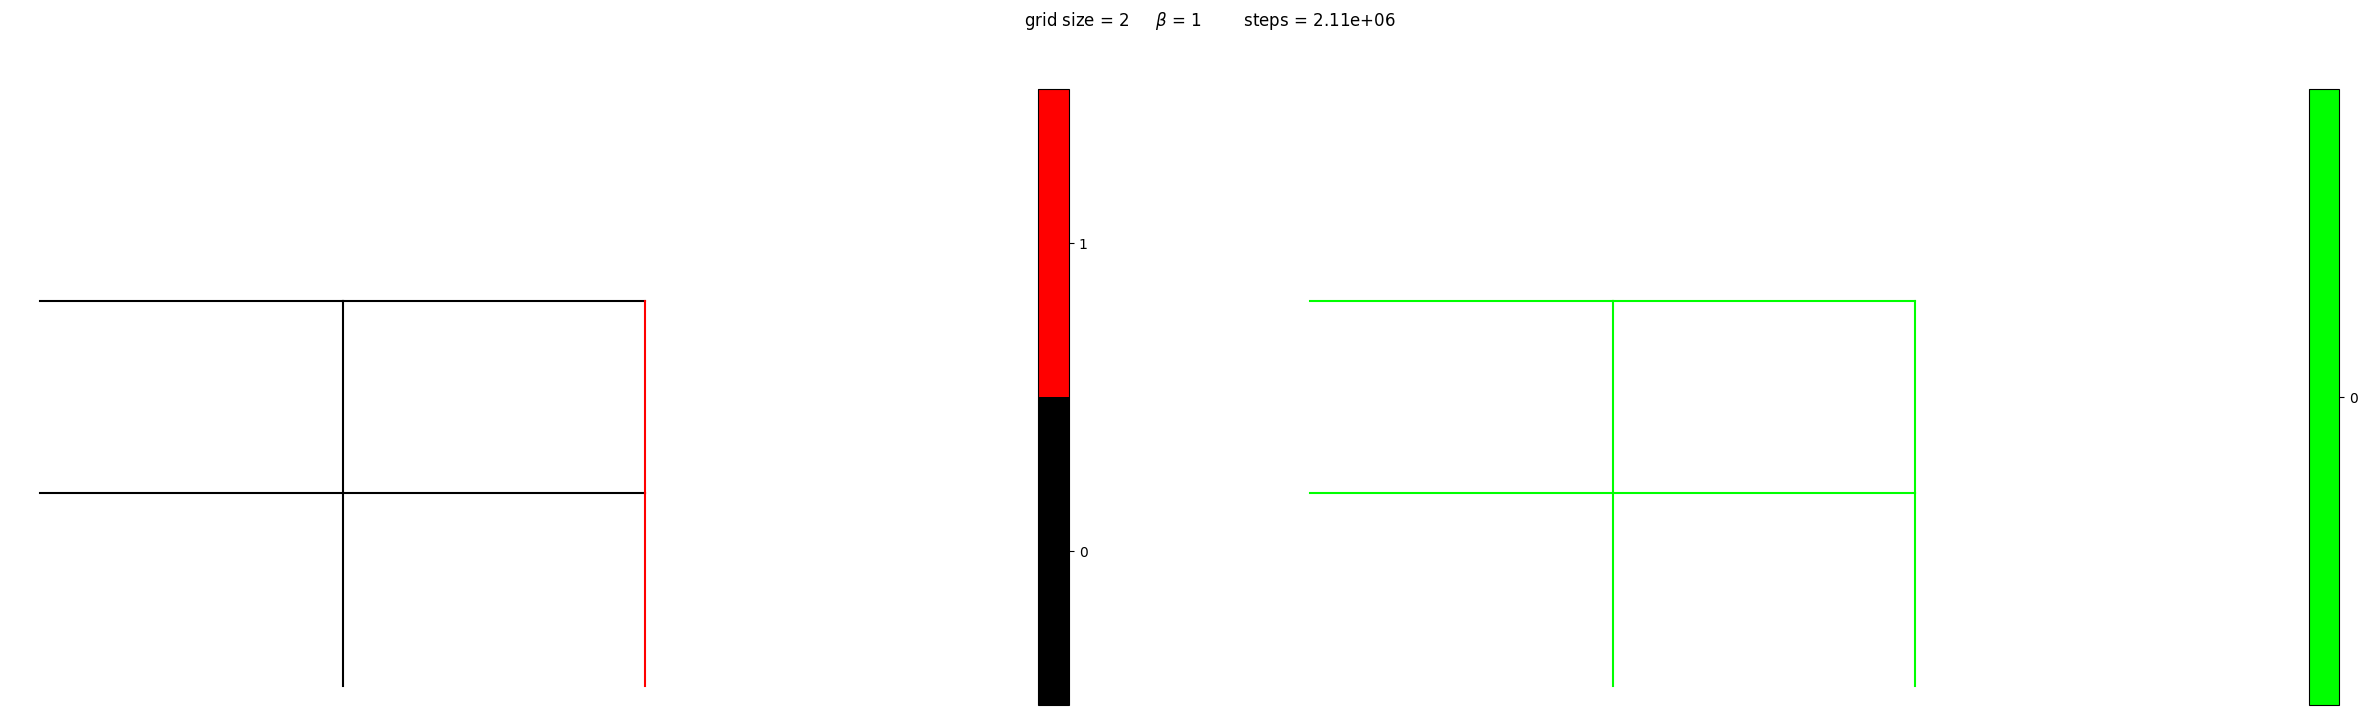

CPU times: total: 27.4 s
Wall time: 29.9 s


In [282]:
%%time 
#m = stateSpace(num_colors = 2, grid_size = 2, beta = 1, init = 'random', algo='glauber')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)  #0.1875
m.step(1_000_000)
print('average number of links: {}'.format(m.get_avg_links()[0]))
print('max number of links: {}'.format(m.get_max_links()[0]))
print('avg local time: {}'.format(m.get_avg_local_time()))
print('steps = {:g}   acceptance ratio = {:.6f}'.format(m.accepted + m.rejected, m.accepted / m.rejected))

plt.style.use("default") # 'dark_background’
m.plot_grid((32,8), colorbar=True) #, file_name = '64_0_9_U2.pdf')

In [276]:
m.data2[0]

array([[[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]]])

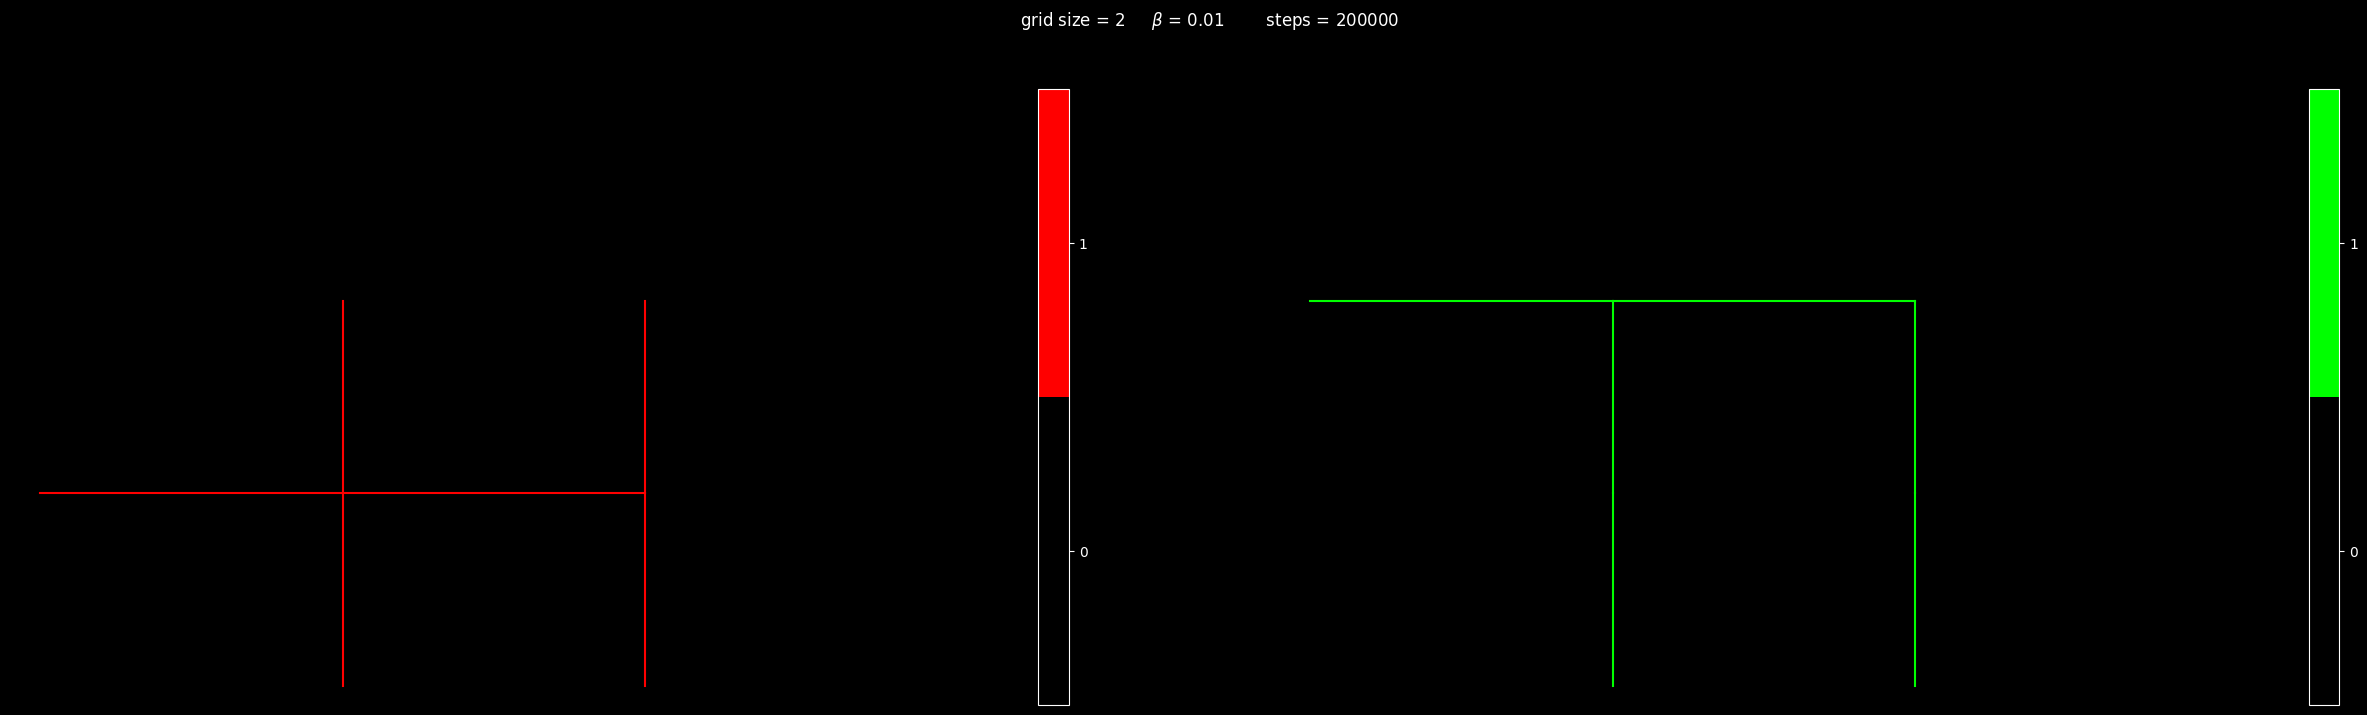

In [27]:
plt.style.use("dark_background") # 'dark_background’
m.plot_grid((32,8), colorbar=True) #, file_name = '64_0_9_U2.pdf')

In [22]:
m.check_state()

True

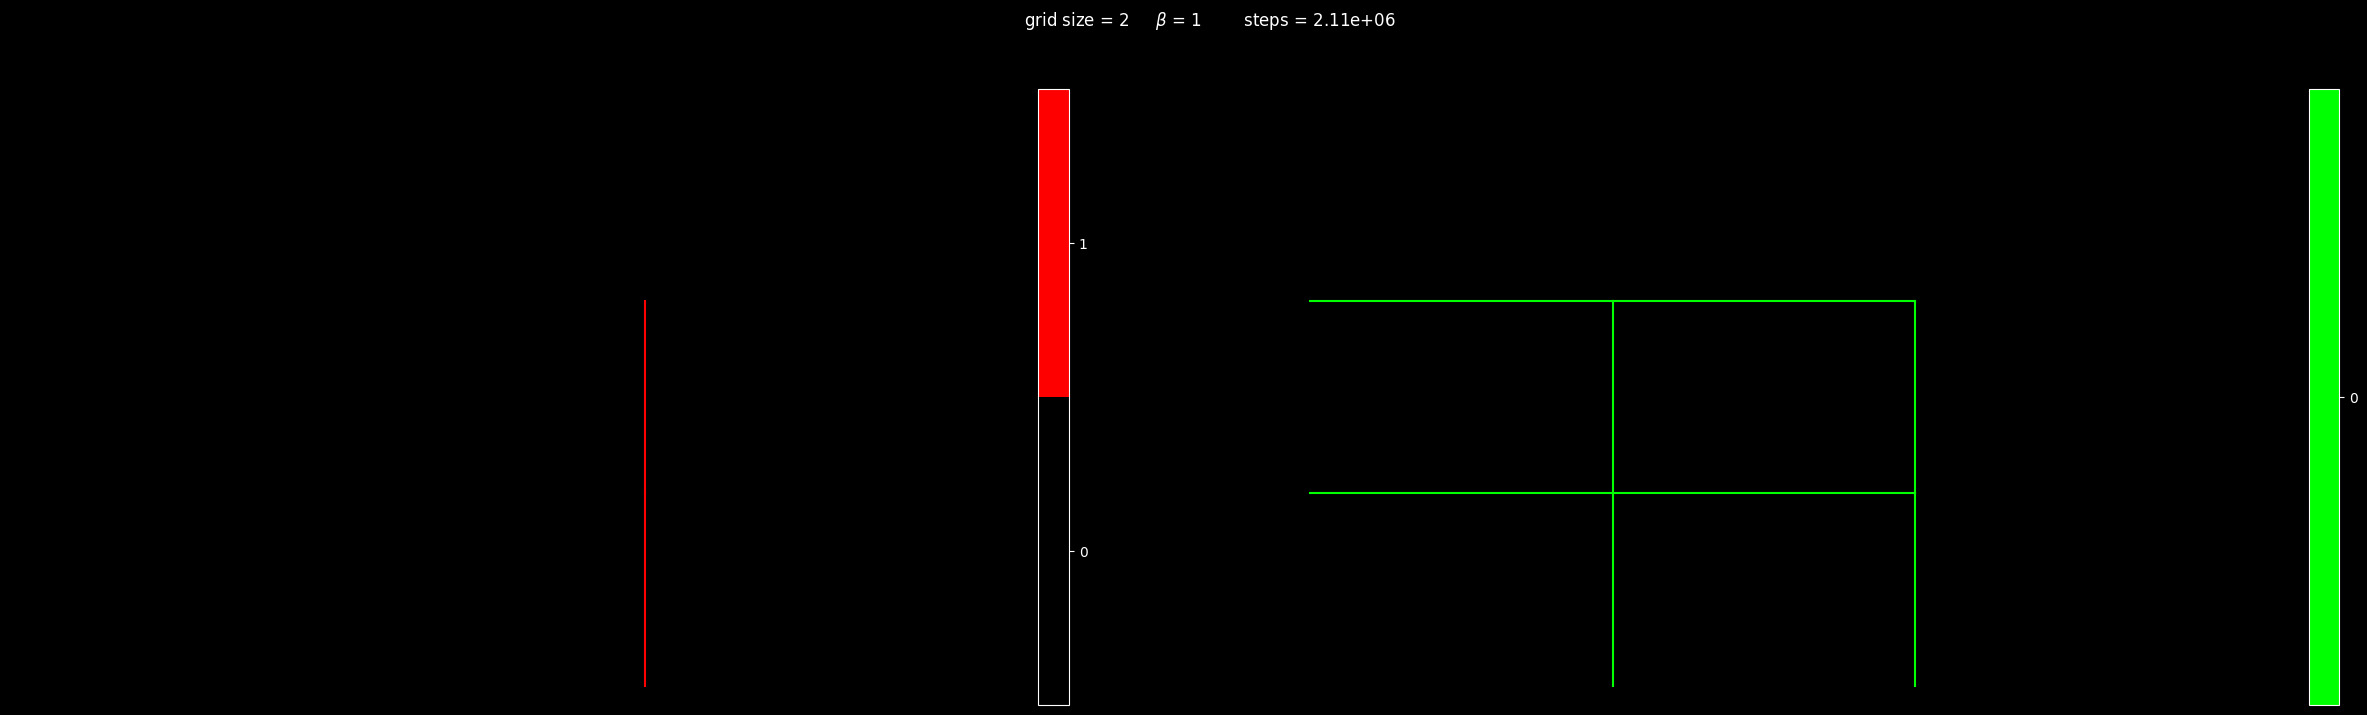

In [283]:
plt.style.use("dark_background") # 'dark_background’
m.plot_grid((32,8), colorbar=True) #, file_name = '64_0_9_U2.pdf')

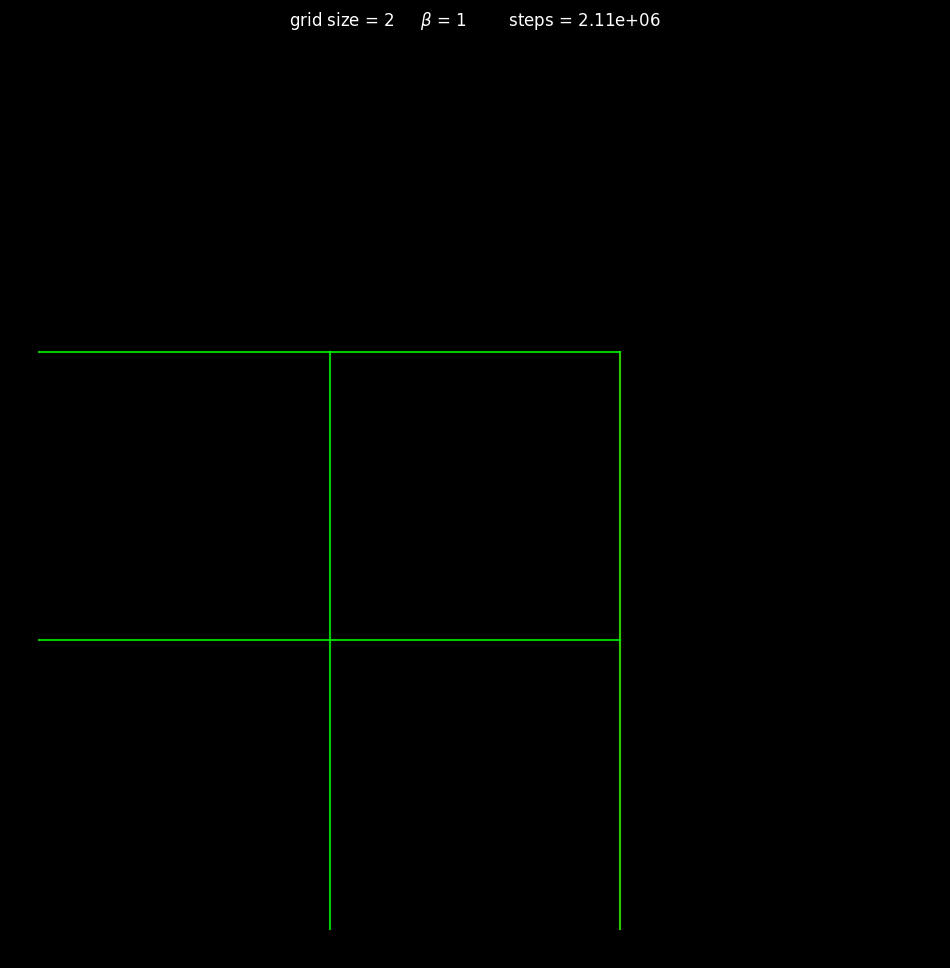

In [284]:
plt.style.use("dark_background")
m.plot_overlap(figsize=(12,12), normalized = False, file_name='64_0_9_U2_M.pdf')

In [82]:
a = 1 if False else 2
print(a)

2


In [58]:
plt.figure(figsize=(26,10))
plt.subplot(1,2,1)
plt.plot( 10_000*np.array(range(0,len(m.data1))) , m.data1, label= 'avg num of links')
plt.legend()

<IPython.core.display.Javascript object>

"\nplt.subplot(1,2,2)\nplt.plot(m.data2, label= 'max num of links', c = 'r')\nplt.legend()\n"

# Build paths

Gready algorithm, choose a random link, build a circuit and then remove all visited links, repeat untile the configuration is empty!

# Simulations loop

In [567]:
%%time

avg_links = []
betas = np.linspace(0.01, 200, 10)

for beta in tqdm(betas):
    m = stateSpace(3, 20, beta, False)  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)
    m.step(3_000_000)
    avg_links.append(m.get_avg_links()[0])
    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

  0%|          | 0/3000000 [00:00<?, ?it/s]

CPU times: total: 14min 13s
Wall time: 14min 46s


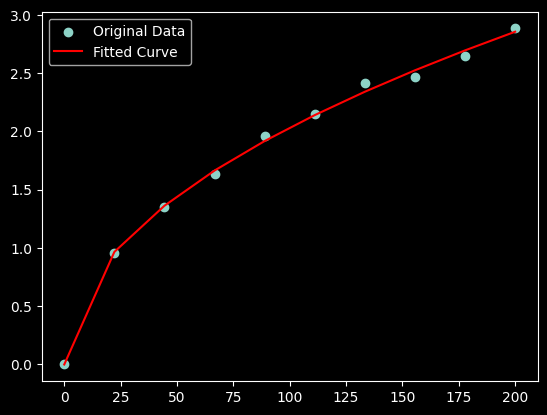

array([ 0.21949745,  0.48616181, -0.0275139 ])

In [568]:
# Define your custom function to fit
def custom_function(x, a, b, c):
    return a * x**b + c


# Fit the function to the data
params, covariance = curve_fit(custom_function, betas, avg_links)

# Extract the fitted parameters
a_fit, b_fit, c_fit = params

# Generate points for the fitted curve
y_fit = custom_function(betas, a_fit, b_fit, c_fit)

# Plot the original data and the fitted curve
plt.scatter(betas, avg_links, label='Original Data')
plt.plot(betas, y_fit, label='Fitted Curve', color='red')
plt.legend()
plt.show()

params

# Dependence of starting state

From simulation at low $\beta$ (less than $1$?) uniform states with odd links are problematic! The chain is irreducible, but to remove wide loops of one link chain you need to build with unifrom +1, which has a low probability, the chain gets stuck in _island like_ states. 
What about random starting states? Can we add (a few) transformation to fix this? Is this a problem? 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

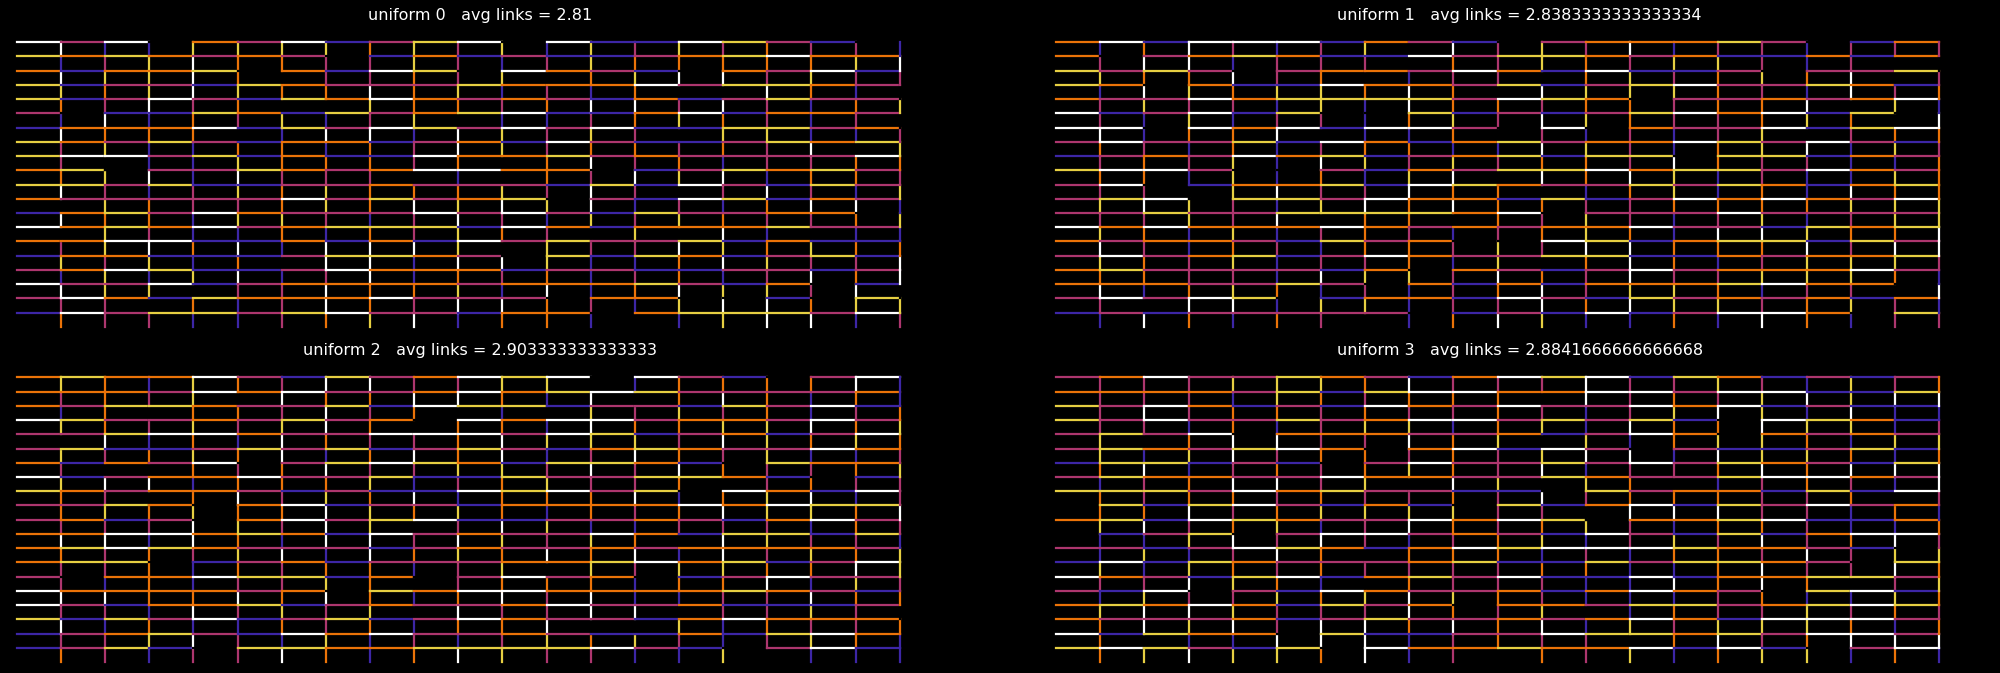

CPU times: total: 1min 55s
Wall time: 2min 1s


In [221]:
%%time
plt.style.use("dark_background")
fig, axes = plt.subplots(2,2, figsize=(32,10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
axes = axes.flatten()


for k in trange(0, 4):
    m = stateSpace(3, 20, 200, init = k)  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False, acceptance_prob)
    m.step(1_000_000)

    cmap = plt.get_cmap('CMRmap')
    # Create a ScalarMappable object using the colormap and normalization
    num_segments = 5 #int(m.get_max_links()[0] +1)
    norm = Normalize(vmin=0, vmax=num_segments)
    sm = ScalarMappable(cmap=cmap, norm=norm)

    m.plot_one_color(0, sm.to_rgba, axes[k])
    axes[k].set_title('uniform {}   avg links = {}'.format(k, np.mean(m.get_avg_links())) )
    axes[k].set_xlim(-1.2, 20.2)  # Replace with your desired x-axis limits
    axes[k].set_ylim(-1.2, 20.2)
    axes[k].axis('off')

plt.show()



In [1]:
%%time
plt.style.use("dark_background")
fig, axes = plt.subplots(1,4, figsize=(34,8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
axes = axes.flatten()


for k in trange(0, 4):
    m = stateSpace(3, 20, 100, init = 'random')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False, acceptance_prob)
    m.step(1_000_000)

    cmap = plt.get_cmap('CMRmap')
    # Create a ScalarMappable object using the colormap and normalization
    num_segments = int(m.get_max_links()[0] +1)
    norm = Normalize(vmin=0, vmax=5)
    sm = ScalarMappable(cmap=cmap, norm=norm)

    m.plot_one_color(0, sm.to_rgba, axes[k])
    axes[k].set_title('random init {}   avg links = {}'.format(k, np.mean(m.get_avg_links())))
    axes[k].set_xlim(-2, 21)  # Replace with your desired x-axis limits
    axes[k].set_ylim(-2, 21)
    axes[k].axis('off')

plt.show()

NameError: name 'plt' is not defined

# Some questions

1. avg number of links as a function of beta
2. time to equilibrium as a function of grid_size (should be $\sim \frac 1 {N^2}$)
3. faster convergence high $\beta$ ?? more steps? confirmed!

- beta = 1      avg_link = 1.75
- beta = 5           1.8
- 100           3.687

4. reject/accept ratio? does it get stuck?
5. forgetting the starting state (empty, uniform, random...)
6. find a correlation metric beetween states, something like:
$$
\sum_{i=1}^3\sum_{e \in E} (m_e^i \langle m \rangle)(n_e^i - \langle n \rangle)
$$
where $\langle m \rangle$ and $\langle n \rangle$ are the links per edge average for each state.

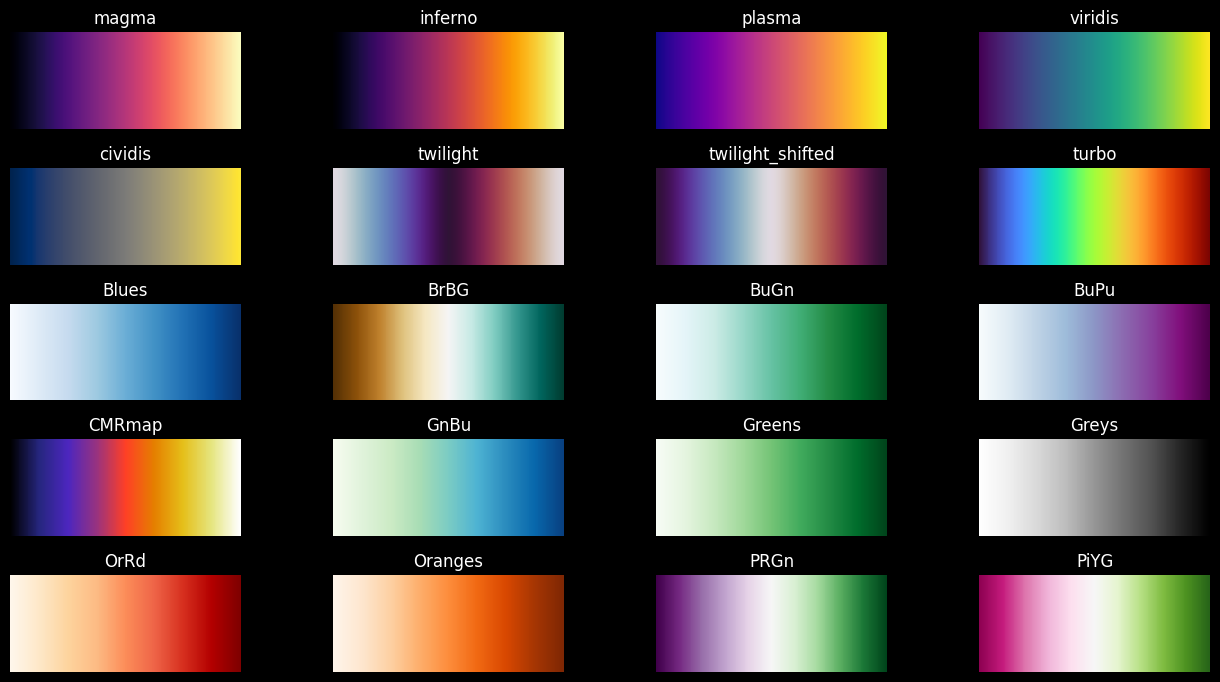

In [145]:

def plot_colormaps(colormaps, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 8))
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            cmap_name = colormaps[i * cols + j]
            cmap = plt.get_cmap(cmap_name)
            
            gradient = np.linspace(0, 1, 256).reshape(1, -1, 1)
            ax.imshow(gradient, aspect='auto', cmap=cmap)
            
            ax.set_title(cmap_name)
            ax.axis('off')

    plt.show()

# Get a list of some Matplotlib colormaps
all_colormaps = plt.colormaps()

# Select a subset of colormaps to showcase
subset_colormaps = all_colormaps[:20]

# Set the number of rows and columns in the grid
num_rows = 5
num_cols = 4

# Display the selected colormaps
plot_colormaps(subset_colormaps, num_rows, num_cols)


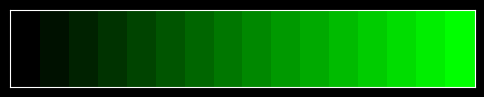

In [455]:

def create_cmap(color):
    if color == 'red':
        colors = [(0, 0, 0), (1, 0, 0)]  # RGB values 
    if color == 'green':
        colors = [(0, 0, 0), (0, 1, 0)]  # RGB values
    if color == 'blue':
        colors = [(0, 0, 0), (0, 0, 1)]  # RGB values

    n_bins = 16  # Number of bins
    cmap_name = "black_to_red"

    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return cmap

def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    plt.show()

# Create and plot the colormap
black_to_red_cmap = create_cmap('green')
plot_colormap(black_to_red_cmap)


# Speed test

numpy array vs python list, delete elment

In [37]:
l = list(range(0,1_000_000))

In [38]:
%%time 
l.remove(100_000)

CPU times: total: 0 ns
Wall time: 1.5 ms


In [41]:
a = np.array(range(0, 1_000_000))

In [42]:
%%time
a = np.delete(a, 100_000)

CPU times: total: 0 ns
Wall time: 1.5 ms
